In [121]:
import seaborn as sns
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [9]:
! python python/heartypatch_downloader_protocol3.py 

python: can't open file 'python/heartypatch_downloader_protocol3.py': [Errno 2] No such file or directory


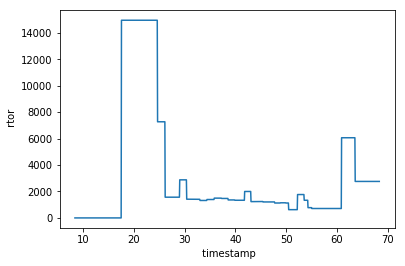

In [122]:


df = pd.read_csv('../python/log.csv')
new_df = df
#f, ax = plt.subplots(figsize=(10,10))

sns.lineplot(x=' timestamp', y=" rtor", data=new_df)

#_ = sns.lineplot(x=new_df.index, y="w", data=new_df)sns.lineplot(x='# seq', y=" hr", data=new_df)

#f.show()


In [124]:
df_ecg.columns = ['rate', 'index']

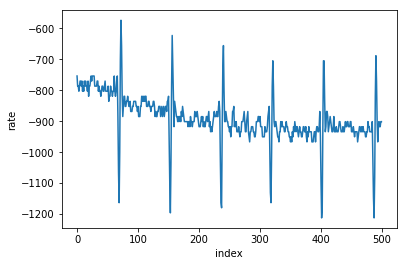

In [129]:
df_ecg = pd.read_csv('../python/log_ecg.csv', sep=None)
df_ecg['index'] = df_ecg.index
df_ecg = df_ecg[['#', 'index']]
df_ecg.columns = ['rate', 'index']
df_ecg.head()
sns.lineplot(x='index', y='rate', data=df_ecg[:500])

In [130]:
class HeartyPatch_TCP_Parser:

    # Packet Validation
    CESState_Init = 0
    CESState_SOF1_Found = 1
    CESState_SOF2_Found = 2
    CESState_PktLen_Found = 3

    # CES CMD IF Packet Format
    CES_CMDIF_PKT_START_1 = 0x0A
    CES_CMDIF_PKT_START_2 = 0xFA
    CES_CMDIF_PKT_STOP = 0x0B

    # CES CMD IF Packet Indices
    CES_CMDIF_IND_LEN = 2
    CES_CMDIF_IND_LEN_MSB = 3
    CES_CMDIF_IND_PKTTYPE = 4
    CES_CMDIF_PKT_OVERHEAD = 5
    CES_CMDIF_PKT_DATA = CES_CMDIF_PKT_OVERHEAD


    ces_pkt_seq_bytes   = 4  # Buffer for Sequence ID
    ces_pkt_ts_bytes   = 8  # Buffer for Timestamp
    ces_pkt_rtor_bytes = 4  # R-R Interval Buffer
    ces_pkt_ecg_bytes  = 4  # Field(s) to hold ECG data

    # Used to be 3
    Expected_Type = 1

    min_packet_size = 19

    def __init__(self):
        self.state = self.CESState_Init
        self.data = bytes()
        self.packet_count = 0
        self.bad_packet_count = 0
        self.bytes_skipped = 0
        self.total_bytes = 0
        self.all_seq = []
        self.all_ts = []
        self.all_rtor = []
        self.all_hr = []
        self.all_ecg = []
        pass

    def add_data(self, new_data):
        self.data += new_data
        self.total_bytes += len(new_data)

    def process_packets(self):
        while len(self.data) >= self.min_packet_size:
            if self.state == self.CESState_Init:
                print('CESState_Init')
                if self.data[0] == self.CES_CMDIF_PKT_START_1:
                    self.state = self.CESState_SOF1_Found
                else:
                    self.data = self.data[1:]    # skip to next byte
                    self.bytes_skipped += 1
                    continue
            elif self.state == self.CESState_SOF1_Found:
                print('CES_CMDIF_PKT_START_2')
                if self.data[1] == self.CES_CMDIF_PKT_START_2:
                    
                    self.state = self.CESState_SOF2_Found
                else:
                    self.state = self.CESState_Init
                    self.data = self.data[1:]    # start from beginning
                    self.bytes_skipped += 1
                    continue
            elif self.state == self.CESState_SOF2_Found:
                print('CESState_SOF2_Found')
                # sanity check header for expected values
                
                #pkt_len = (256 * (self.data[self.CES_CMDIF_IND_LEN_MSB])) + self.data[self.CES_CMDIF_IND_LEN]
                pkt_len = (1 * (self.data[self.CES_CMDIF_IND_LEN_MSB])) + self.data[self.CES_CMDIF_IND_LEN]
                print(pkt_len)
                # Make sure we have a full packet
                if len(self.data) < (self.CES_CMDIF_PKT_OVERHEAD + pkt_len + 2):
                    print('break')
                    break

                if (self.data[self.CES_CMDIF_IND_PKTTYPE]  != self.Expected_Type
                    or self.data[self.CES_CMDIF_PKT_OVERHEAD+pkt_len+1] != self.CES_CMDIF_PKT_STOP):
                    
                    print('unexpected_type')
                    if True:
                    #      print('pkt_len', pkt_len)
                    #      print(self.data[self.CES_CMDIF_IND_PKTTYPE], self.Expected_Type)
                    #      print(self.data[self.CES_CMDIF_IND_PKTTYPE] != self.Expected_Type)
                    #
                    #      for j in range(0, self.CES_CMDIF_PKT_OVERHEAD):
                    #          print format(ord(self.data[j]),'02x'),
                    #      print

    #                        for j in range(self.CES_CMDIF_PKT_OVERHEAD, self.CES_CMDIF_PKT_OVERHEAD+pkt_len):
    #                            print format(ord(self.data[j]),'02x'),
    #                        print
    #
    #                        for j in range(self.CES_CMDIF_PKT_OVERHEAD+pkt_len, self.CES_CMDIF_PKT_OVERHEAD+pkt_len+2):
    #                            print format(ord(self.data[j]),'02x'),
    #                        print
    #                        print self.CES_CMDIF_PKT_STOP,
    #                        print ord(self.data[self.CES_CMDIF_PKT_OVERHEAD+pkt_len+2]) != self.CES_CMDIF_PKT_STOP
    #                        print
                        pass

                # unexpected packet format
                    self.state = self.CESState_Init
                    self.data = self.data[1:]    # start from beginning
                    self.bytes_skipped += 1
                    self.bad_packet_count += 1
                    continue
                        # Parse Payload
                payload = self.data[self.CES_CMDIF_PKT_OVERHEAD:self.CES_CMDIF_PKT_OVERHEAD+pkt_len+1]

                ptr = 0
                # Process Sequence ID
                seq_id = struct.unpack('<I', payload[ptr:ptr+4])[0]
                self.all_seq.append(seq_id)
                ptr += self.ces_pkt_seq_bytes

                # Process Timestamp
                ts_s = struct.unpack('<I', payload[ptr:ptr+4])[0]
                ts_us = struct.unpack('<I', payload[ptr+4:ptr+8])[0]
                timestamp = ts_s + ts_us/1000000.0
                self.all_ts.append(timestamp)
                ptr += self.ces_pkt_ts_bytes

                # Process R-R Interval
                rtor = struct.unpack('<I', payload[ptr:ptr+4])[0]
                self.all_rtor.append(rtor)
                if rtor == 0:
                    self.all_hr.append(0)
                else:
                    self.all_hr.append(60000.0/rtor)

                ptr += self.ces_pkt_rtor_bytes


                assert ptr == 16
                assert pkt_len == (16 + 8 * 4)
                # Process Sequence ID
                while ptr < pkt_len:
                    ecg = struct.unpack('<i', payload[ptr:ptr+4])[0] / 1000.0
                    self.all_ecg.append(ecg)
                    ptr += self.ces_pkt_ecg_bytes

                self.packet_count += 1                    
                self.state = self.CESState_Init
                self.data = self.data[self.CES_CMDIF_PKT_OVERHEAD+pkt_len+2:]    # start from beginning
                
                
            

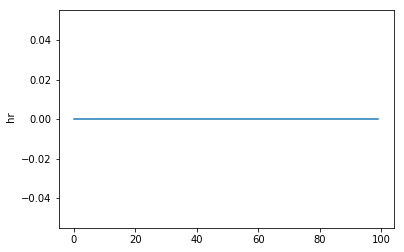

In [123]:
sns.lineplot(x=df.index[0:100], y=" hr", data=new_df[0:100])